## Text-to-Image Classifier with Attention Mechanisms Inspired by Auditory Perception
### Ben Richardson and Kendra Noneman
CMU 10-701: Introduction to Machine Learning (Fall 2022)

In [1]:
# Import all packages/toolboxes

from PIL import Image
from matplotlib.pyplot import imshow
import requests
import torch
import numpy as np
import pandas as pd
import math
from gtts import gTTS
import matplotlib.pyplot as plt
import seaborn as sns
from playsound import playsound
from audio2numpy import open_audio
import ffmpeg
import librosa
from scipy.signal import butter,filtfilt,find_peaks,stft
from scipy.fft import fft
import pyttsx3
from scipy.io import wavfile
import soundfile as sf
from pydub import AudioSegment
from pydub.silence import split_on_silence
import IPython.display as ipd
from scipy.fftpack import dct

%matplotlib inline

# Library documentation: https://huggingface.co/docs/transformers/model_doc/clip
from transformers import CLIPProcessor, CLIPModel, AutoTokenizer, CLIPImageProcessor

## 1. Show steps for simple example with one image
### (a) Load example image

(640, 480)


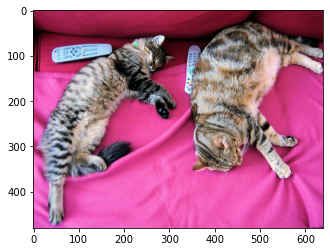

In [2]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
print(image.size)
imshow(image)

### (c) Tokenize image label (before biasing with speech features)

In [3]:
model_name = "openai/clip-vit-base-patch32"

tokenizer = AutoTokenizer.from_pretrained(model_name)
image_label = "a photo of a cat"

encoding = tokenizer(image_label)
print(encoding)

{'input_ids': [49406, 320, 1125, 539, 320, 2368, 49407], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}


### (d) Convert text to speech in .wav format

In [4]:
from gtts import gTTS 
from gtts.tokenizer.pre_processors import abbreviations, end_of_line 
from pygame import mixer  
from pydub import AudioSegment 
import time 

tts = gTTS(image_label, slow=False, tld='com.au', pre_processor_funcs = [abbreviations, end_of_line]) 
tts.save('image_sound.mp3')

sound = AudioSegment.from_mp3("image_sound.mp3")
sound.export("image_sound.wav", format="wav")

mixer.init()
mixer.music.load("image_sound.mp3")
mixer.music.play()
time.sleep(2)

pygame 2.1.2 (SDL 2.0.18, Python 3.8.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


### (e) Extract speech signal 

Shape         (14784,)
Seconds       1.848


C:\Users\benri\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:7553: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


Text(0.5, 0, 'Seconds')

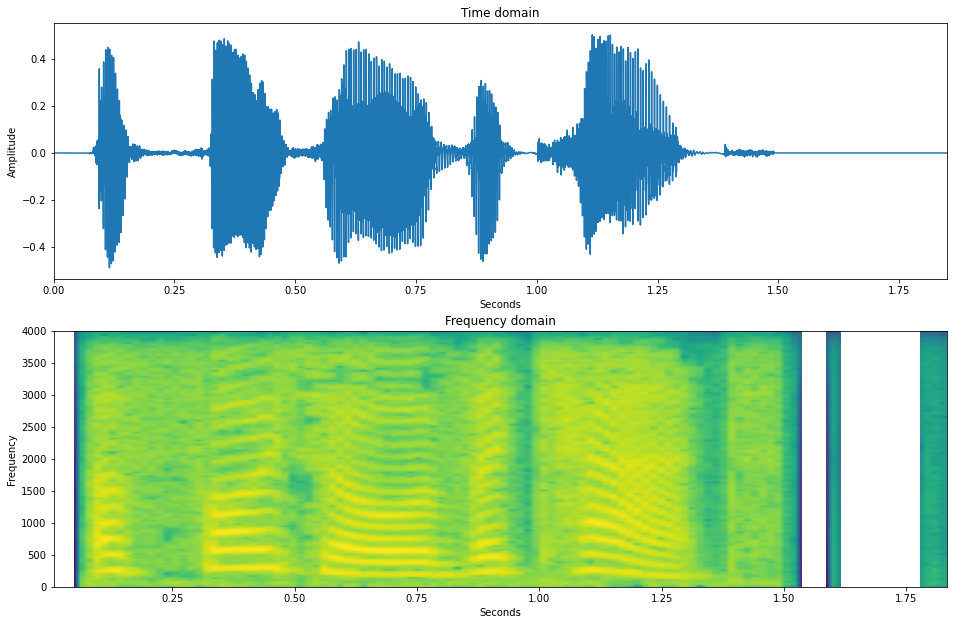

In [5]:
audio_file = "image_sound.wav"
ipd.Audio(audio_file)

sr, s = wavfile.read(audio_file)

samples, sample_rate = librosa.load(audio_file, mono=True, sr=8000)
print("Shape        ",samples.shape)
print("Seconds      ",samples.shape[0]/sample_rate)

sig = samples
sr = sample_rate
t = [i/sr for i in range(len(sig))]
    
fig = plt.figure(figsize=(16,9))
plt.subplots_adjust(left=None, bottom=0.01, right=None, top=None, wspace=None, hspace=None)
ax1 = fig.add_subplot(211)
ax1 = sns.lineplot(x=t,y=sig)
ax1.set_title('Time domain')
ax1.set_ylabel('Amplitude')
ax1.set_xlabel('Seconds')
ax1.set_xlim([t[0],t[-1]])

ax2 = fig.add_subplot(212)
if(len(sig) < 256):
    z = np.zeros(int(256 - len(sig)))
    sig = np.append(sig, z)
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(sig, Fs=sr)
ax2.set_title('Frequency domain')
ax2.set_ylabel('Frequency')
ax2.set_xlabel('Seconds')

### (f) Use Vocal Activity Detection (VAD) to remove parts of signal with no speech

Shape         (11000,)
Seconds       1.375


C:\Users\benri\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:7553: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


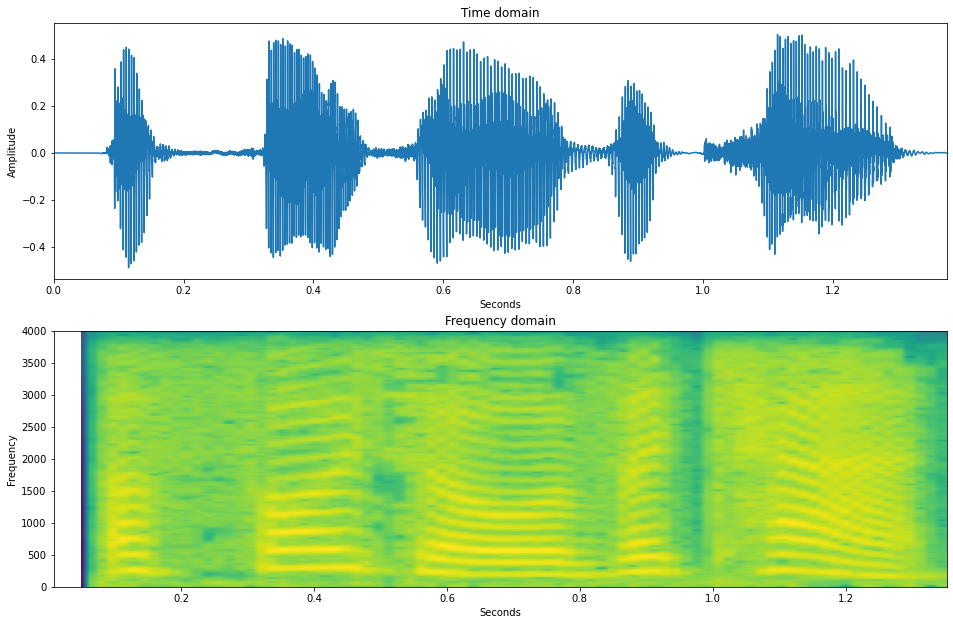

In [6]:
total_s = int(samples.shape[0]/1000)
vad_signal = []
for i in range(total_s):
    sig = samples[i*1000:(i+1)*1000]
    rms = math.sqrt(np.square(sig).mean())
    if(rms > 0.012):
        vad_signal = np.append(vad_signal,sig)
print("Shape        ",vad_signal.shape)
print("Seconds      ",vad_signal.shape[0]/sample_rate)


#plot_signal(vad_signal,sample_rate)
sig = vad_signal
sr = sample_rate
t = [i/sr for i in range(len(sig))]
    
fig = plt.figure(figsize=(16,9))
plt.subplots_adjust(left=None, bottom=0.01, right=None, top=None, wspace=None, hspace=None)
ax1 = fig.add_subplot(211)
ax1 = sns.lineplot(x=t,y=sig)
ax1.set_title('Time domain')
ax1.set_ylabel('Amplitude')
ax1.set_xlabel('Seconds')
ax1.set_xlim([t[0],t[-1]])

ax2 = fig.add_subplot(212)
if(len(sig) < 256):
    z = np.zeros(int(256 - len(sig)))
    sig = np.append(sig, z)
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(sig, Fs=sr)
ax2.set_title('Frequency domain')
ax2.set_ylabel('Frequency')
ax2.set_xlabel('Seconds')

sf.write('vad_signal.wav', vad_signal, sample_rate, subtype='PCM_16')
ipd.Audio('vad_signal.wav')

### (g) Use pre-emphasis filter to flatten spectrum of signal

Shape         (11000,)
Seconds       1.375


C:\Users\benri\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:7553: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


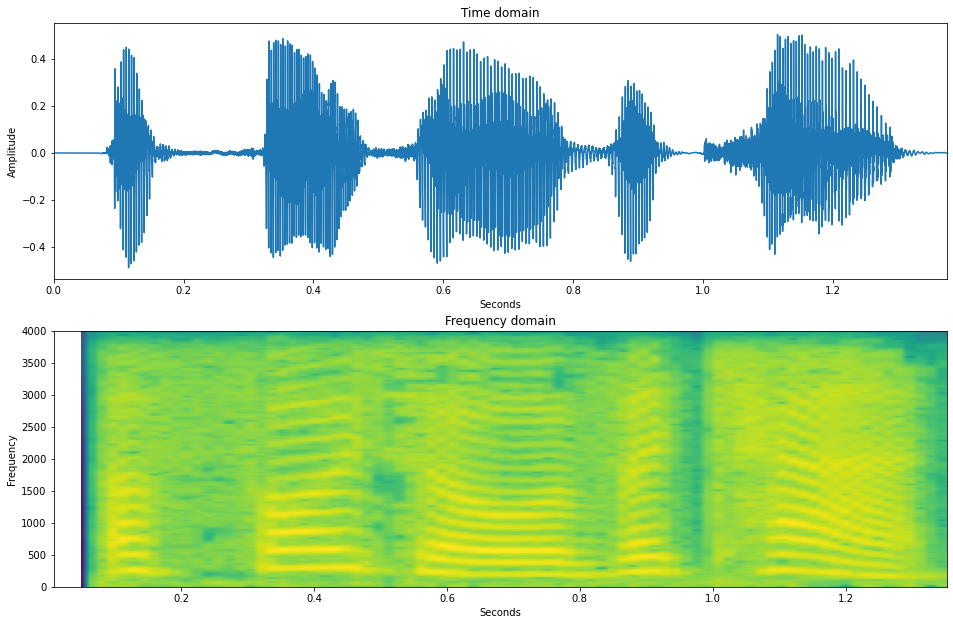

In [7]:
emph_signal = np.append(vad_signal[0], vad_signal[1:] - 0.95 * vad_signal[:-1])
print("Shape        ",emph_signal.shape)
print("Seconds      ",emph_signal.shape[0]/sample_rate)

    
fig = plt.figure(figsize=(16,9))
plt.subplots_adjust(left=None, bottom=0.01, right=None, top=None, wspace=None, hspace=None)
ax1 = fig.add_subplot(211)
ax1 = sns.lineplot(x=t,y=sig)
ax1.set_title('Time domain')
ax1.set_ylabel('Amplitude')
ax1.set_xlabel('Seconds')
ax1.set_xlim([t[0],t[-1]])

ax2 = fig.add_subplot(212)
if(len(sig) < 256):
    z = np.zeros(int(256 - len(sig)))
    sig = np.append(sig, z)
powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(sig, Fs=sr)
ax2.set_title('Frequency domain')
ax2.set_ylabel('Frequency')
ax2.set_xlabel('Seconds')

sf.write('emph_signal.wav', emph_signal, sample_rate, subtype='PCM_16')
ipd.Audio('emph_signal.wav')

### (h) Find the peaks of signal, ideally pulling out each word

[0.413535   0.32736391 0.40839255 0.36198118 0.60436517]


(0.0, 1.374875)

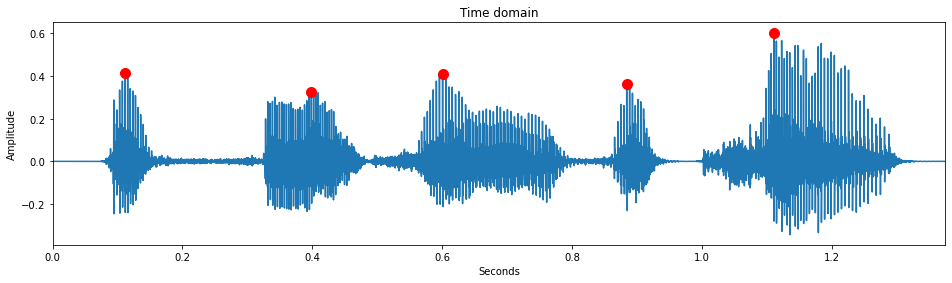

In [8]:
peaks, _ = find_peaks(emph_signal,prominence=0.5,distance=1500)
ids_scale = emph_signal[peaks]
print(ids_scale)

sig = emph_signal
sr = sample_rate
t = [i/sr for i in range(len(sig))]
    
fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(211)
ax1 = sns.lineplot(x=t,y=sig)
ax1.plot(peaks/sr, emph_signal[peaks], "ro", markersize=10)
ax1.set_title('Time domain')
ax1.set_ylabel('Amplitude')
ax1.set_xlabel('Seconds')
ax1.set_xlim([t[0],t[-1]])


### (i) Use signal peaks to bias the attention mask of the text tokenizer

In [9]:
model_name = "openai/clip-vit-base-patch32"

tokenizer = AutoTokenizer.from_pretrained(model_name)
image_label = "a photo of a cat"

encoding = tokenizer(image_label)
print(encoding)

{'input_ids': [49406, 320, 1125, 539, 320, 2368, 49407], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}


In [10]:
#model = CLIPModel.from_pretrained(model_name)
image_processor = CLIPImageProcessor.from_pretrained(model_name)
print(image_processor)
#processor = CLIPProcessor.from_pretrained(model_name)

#inputs = processor(text=["a photo of a cat"], images=image, return_tensors="pt", padding=True)
#print(inputs["input_ids"])

CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "CLIPFeatureExtractor",
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}



In [11]:



model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)
print(processor.feature_extractor.crop_size)

{'height': 224, 'width': 224}


In [23]:
inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)
                                        
print(inputs["input_ids"])
print(inputs["input_ids"].shape)

tensor([[49406,   320,  1125,   539,   320,  2368, 49407],
        [49406,   320,  1125,   539,   320,  1929, 49407]])
torch.Size([2, 7])


In [24]:
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities
print(probs)


tensor([[0.5000, 0.5000]], grad_fn=<SoftmaxBackward0>)


In [ ]:
sig, sr = open_audio('image_sound.mp3')

[F, T, Z] = stft(sig, fs=sr)

plt.figure()
plt.imshow(np.abs(Z))
plt.title('Short-time Fourier transform (STFT)')
plt.colorbar

fig = plt.figure()
ax = plt.axes()
time_length = np.shape(sig)[0]/sr
x = np.linspace(0,time_length,num=int(np.round(sr*time_length)))
ax.plot(x,sig)
ax.set_title('Voice Waveform')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
ax.grid(True)
plt.savefig('cat_waveform.png', bbox_inches='tight')

In [ ]:
from scipy.signal import find_peaks, peak_prominences, peak_widths

peaks, _ = find_peaks(sig, height=0.2,distance=4000)
prominences = peak_prominences(sig, peaks)[0]

plt.plot(sig)
plt.plot(peaks, sig[peaks], "x")
plt.plot(np.zeros_like(sig), "--", color="gray")
plt.show()

print(peaks)
print(prominences)

In [ ]:
# low pass filter, take peaks
def butter_lowpass_filter(data, cutoff, sr, order):
    nyq = 0.5 * sr
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y
signal_lpf = butter_lowpass_filter(sig, 20, sr, 2)
pitches,magnitudes = librosa.piptrack(y=sig, sr=sr)
print(sr)
print(sig.shape)
print(pitches.shape)
print(magnitudes.shape)
plt.figure()
ax = plt.axes()
ax.plot(pitches)
plt.title('Pitch')
plt.colorbar
plt.figure()
ax = plt.axes()
ax.plot(magnitudes)
plt.title('Magnitude')
plt.colorbar

In [ ]:
plt.figure()
plt.plot(signal_lpf)
plt.title('Low Pass Filtered Cat')
# Find num_words peak
num_words = inputs["input_ids"].shape[1] - 2
peaks, properties = find_peaks(signal_lpf,height=0.01,prominence=0.015)
print(peaks)
print(properties['peak_heights'])
heights_cat = properties['peak_heights']
heights_cat = heights_cat[0:num_words]
normalized_heights_cat = (heights_cat - np.min(heights_cat))/(np.max(heights_cat) - np.min(heights_cat))
print(normalized_heights_cat)

### Multimodal Model:

##### CLIPModel:
Model configuration class with all the parameters of the model. Initializing with a config file does not load the weights associated with the model, only the configuration.
 
##### from_pretrained:
Changes the weights (including mapping hidden states to vocabulary, pruning and initializing weights, tying the weights between the input embeddings and the output embeddings, etc...)
https://huggingface.co/docs/transformers/v4.24.0/en/main_classes/model#transformers.PreTrainedModel.from_pretrained

Options for CLIP pre-trained openai models (4 of them):
https://huggingface.co/openai

##### CLIPProcessor:
Constructs a CLIP processor which wraps a CLIP feature extractor and a CLIP tokenizer into a single processor

In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image.show()

In [ ]:
inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)
print(inputs["input_ids"])
print(inputs["input_ids"].shape)
#image_features = model.get_image_features(**inputs,output_attentions=1)


In [ ]:
## Text to Speech, determine pitch contour
text_to_convert = "a photo of a cat"
language = "en"
import pyttsx3  
s = pyttsx3.init()   
s.say(text_to_convert)  
s.save_to_file(text_to_convert, 'speech.mp3')
s.runAndWait()
voice = s.getProperty('voice')   #getting to know current volume level (min=0 and max=1)
print(voice)
signal, sr = open_audio('speech.mp3')
[F, T, Z] = stft(signal, fs=sr)
#print(F)
plt.figure()
plt.imshow(np.abs(Z))
plt.title('A Photo of A Cat STFT')
plt.colorbar
# SIGNAL
fig = plt.figure()
ax = plt.axes()
time_length = np.shape(signal)[0]/sr
x = np.linspace(0,time_length,num=int(np.round(sr*time_length)))
ax.plot(x,signal)
ax.set_title('A Photo of A Cat Waveform')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
ax.grid(True)
plt.savefig('cat_waveform.png', bbox_inches='tight')

# low pass filter, take peaks
def butter_lowpass_filter(data, cutoff, sr, order):
    nyq = 0.5 * sr
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y
signal_lpf = butter_lowpass_filter(signal, 20, sr, 2)
pitches,magnitudes = librosa.piptrack(y=signal, sr=sr)
print(sr)
print(signal.shape)
print(pitches.shape)
print(magnitudes.shape)
plt.figure()
ax = plt.axes()
ax.plot(pitches)
plt.title('Pitch')
plt.colorbar
plt.figure()
ax = plt.axes()
ax.plot(magnitudes)
plt.title('Magnitude')
plt.colorbar


plt.figure()
plt.plot(signal_lpf)
plt.title('Low Pass Filtered Cat')
# Find num_words peak
num_words = inputs["input_ids"].shape[1] - 2
peaks, properties = find_peaks(signal_lpf,height=0.01,prominence=0.015)
print(peaks)
print(properties['peak_heights'])
heights_cat = properties['peak_heights']
heights_cat = heights_cat[0:num_words]
normalized_heights_cat = (heights_cat - np.min(heights_cat))/(np.max(heights_cat) - np.min(heights_cat))
print(normalized_heights_cat)


## SAME THING FOR DOG
text_to_convert = "a photo of a dog"
language = "en"
s = pyttsx3.init()   
s.say(text_to_convert)  
s.save_to_file(text_to_convert, 'speech.mp3')
s.runAndWait()

signal, sr = open_audio('speech.mp3')
# SIGNAL
fig = plt.figure()
ax = plt.axes()
time_length = np.shape(signal)[0]/sr
x = np.linspace(0,time_length,num=int(np.round(sr*time_length)))
ax.plot(x,signal)
plt.title('A Photo of A Dog Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
ax.grid(True)
fig.savefig('dog_waveform.png', bbox_inches='tight')

# low pass filter, take peaks
def butter_lowpass_filter(data, cutoff, sr, order):
    nyq = 0.5 * sr
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y
signal_lpf = butter_lowpass_filter(signal, 20, sr, 2)
plt.figure()
plt.plot(signal_lpf)
plt.title('Low Pass Filtered Dog')
# Find num_words peak
num_words = inputs["input_ids"].shape[1] - 2
peaks, properties = find_peaks(signal_lpf,height=0.01,prominence=0.011)
print(peaks)
print(properties['peak_heights'])
heights_dog = properties['peak_heights']
heights_dog = heights_dog[0:num_words]
normalized_heights_dog = (heights_dog - np.min(heights_dog))/(np.max(heights_dog) - np.min(heights_dog))
print(normalized_heights_dog)

In [ ]:
# Find the n words with largest auditory cue, and then set the attention mask to 1 only for those words
#print(normalized_heights_cat)
#np.random.shuffle(normalized_heights_cat)
#np.random.shuffle(normalized_heights_dog)
#print(normalized_heights_cat)

attention_mask_cat = np.concatenate([np.ones(1),heights_cat,np.ones(1)])
attention_mask_dog = np.concatenate([np.ones(1),heights_dog,np.ones(1)])
print(attention_mask_cat)
print(attention_mask_dog)
print(4000*attention_mask_cat)

inputs["attention_mask"] = torch.Tensor([4000*attention_mask_cat,4000*attention_mask_dog])
#inputs["attention_mask"] = torch.Tensor([[1,1,1,1,1,1,1],[1,1,1,1,1,1,1]])

#torch.Tensor([np.linspace(1,0,num=inputs["input_ids"].shape[1]).tolist(),np.linspace(1,0,num=inputs["input_ids"].shape[1]).tolist()])
#print(np.linspace(1,0,num=inputs["input_ids"].shape[1]).tolist())


In [ ]:
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities


In [ ]:
print(probs)

In [ ]:
#print(image_features)